In [1]:
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from evaluate import load
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
#  You can install and import any other libraries if needed

/home/didiersalest/NLP_HW3_2/NLP-Exercise-3/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Some Chinese punctuations will be tokenized as [UNK], so we replace them with English ones
token_replacement = [
    ["：" , ":"],
    ["，" , ","],
    ["“" , "\""],
    ["”" , "\""],
    ["？" , "?"],
    ["……" , "..."],
    ["！" , "!"]
]

In [3]:

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased", cache_dir="./cache/")

In [4]:
tokenizer(text="Testing the output.", text_pair="Testing second sentence.", padding = True, truncation=True, return_tensors="pt", return_attention_mask=True, return_token_type_ids=True)

{'input_ids': tensor([[ 101, 5604, 1996, 6434, 1012,  102, 5604, 2117, 6251, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [5]:
class SemevalDataset(Dataset):
    def __init__(self, split="train") -> None:
        super().__init__()
        assert split in ["train", "validation", "test"]
        self.data = load_dataset(
            "sem_eval_2014_task_1", split=split, trust_remote_code=True, cache_dir="./cache/"
        ).to_list()

    def __getitem__(self, index):
        d = self.data[index]
        # Replace Chinese punctuations with English ones
        for k in ["premise", "hypothesis"]:
            for tok in token_replacement:
                d[k] = d[k].replace(tok[0], tok[1])
        return d

    def __len__(self):
        return len(self.data)

data_sample = SemevalDataset(split="train").data[:3]
print(f"Dataset example: \n{data_sample[0]} \n{data_sample[1]} \n{data_sample[2]}")

Dataset example: 
{'sentence_pair_id': 1, 'premise': 'A group of kids is playing in a yard and an old man is standing in the background', 'hypothesis': 'A group of boys in a yard is playing and a man is standing in the background', 'relatedness_score': 4.5, 'entailment_judgment': 0} 
{'sentence_pair_id': 2, 'premise': 'A group of children is playing in the house and there is no man standing in the background', 'hypothesis': 'A group of kids is playing in a yard and an old man is standing in the background', 'relatedness_score': 3.200000047683716, 'entailment_judgment': 0} 
{'sentence_pair_id': 3, 'premise': 'The young boys are playing outdoors and the man is smiling nearby', 'hypothesis': 'The kids are playing outdoors near a man with a smile', 'relatedness_score': 4.699999809265137, 'entailment_judgment': 1}


In [6]:
# Define the hyperparameters
# You can modify these values if needed
lr = 3e-5
epochs = 3
train_batch_size = 8
validation_batch_size = 8

In [7]:
# TODO1: Create batched data for DataLoader
# `collate_fn` is a function that defines how the data batch should be packed.
# This function will be called in the DataLoader to pack the data batch.

def collate_fn(batch):
    # TODO1-1: Implement the collate_fn function
    # Write your code here
    # The input parameter is a data batch (tuple), and this function packs it into tensors.
    # Use tokenizer to pack tokenize and pack the data and its corresponding labels.
    # Return the data batch and labels for each sub-task.
    premises = [data_instance["premise"] for data_instance in batch]
    hypothesis = [data_instance["hypothesis"] for data_instance in batch]
    relatedness_scores = [data_instance["relatedness_score"] for data_instance in batch]
    entailment_judgments = [data_instance["entailment_judgment"] for data_instance in batch]

    input_texts = tokenizer(text=premises, text_pair=hypothesis, padding = True, truncation=True, return_tensors="pt", return_attention_mask=True, return_token_type_ids=True)

    relatedness_scores=torch.FloatTensor(relatedness_scores)
    entailment_judgments=torch.LongTensor(entailment_judgments)

    return input_texts, relatedness_scores, entailment_judgments

# TODO1-2: Define your DataLoader
dl_train = torch.utils.data.DataLoader(dataset=SemevalDataset(split="train"), collate_fn=collate_fn, batch_size=train_batch_size, shuffle=True, num_workers=32) # Write your code here
dl_validation = torch.utils.data.DataLoader(dataset=SemevalDataset(split="validation"), collate_fn=collate_fn, batch_size=validation_batch_size, shuffle=False, num_workers=32)  # Write your code here
dl_test = torch.utils.data.DataLoader(dataset=SemevalDataset(split="test"), collate_fn=collate_fn, batch_size=validation_batch_size, shuffle=False, num_workers=32) # Write your code here

/home/didiersalest/NLP_HW3_2/NLP-Exercise-3/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
print(next(iter(dl_train)))

({'input_ids': tensor([[  101,  2048,  2336,  2024,  5291,  1999,  6530,  2300,   102,  2048,
          2336,  2024,  5291,  1999, 15405,  2300,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  101,  1996,  2304,  1998,  2317,  3899,  2003,  2770, 19350,   102,
          1996,  2304,  1998,  2317,  3899,  2003,  3564,  2006,  1037,  2665,
          4220,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  101,  1037,  2879,  4147,  1037, 17983,  3797,  2003,  2770, 22985,
          2006,  1996,  7525,  2940,   102,  1037,  2879,  2003,  2770,  2006,
          1996,  3509,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  101,  2045,  2003,  2053,  3899,  2770,  2007,  1037,  7454,   102,
          1037,  3899,  2003,  2770,  2007,  1037,  7454,   102,     0,     0,
             0,     0, 

In [15]:
# TODO2: Construct your model
class RegressionModel(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Write your code here
        # Define what modules you will use in the model
        # Please use "google-bert/bert-base-uncased" model (https://huggingface.co/google-bert/bert-base-uncased)
        # Besides the base model, you may design additional architectures by incorporating linear layers, activation functions, or other neural components.
        # Remark: The use of any additional pretrained language models is not permitted.

        num_classes = 3 # Based on our data
        self.bert_model = BertModel.from_pretrained("google-bert/bert-base-uncased", cache_dir="./cache/")
        self.dropout = torch.nn.Dropout(0.3)

        self.regression_head = torch.nn.Linear(self.bert_model.config.hidden_size,1)
        # self.classification_head=torch.nn.Linear(self.bert_model.config.hidden_size,num_classes)
        
    def forward(self, **kwargs):
        # Write your code here
        # Forward pass

        output=self.bert_model(input_ids=kwargs.get("input_ids"), 
                               token_type_ids=kwargs.get("token_type_ids"), 
                               attention_mask=kwargs.get("attention_mask"))
        output_dropout = self.dropout(output.pooler_output)
        output_regression = self.regression_head(output_dropout)
        # output_classification = self.classification_head(output_dropout)

        return output_regression

In [16]:
# TODO2: Construct your model
class ClassificationModel(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Write your code here
        # Define what modules you will use in the model
        # Please use "google-bert/bert-base-uncased" model (https://huggingface.co/google-bert/bert-base-uncased)
        # Besides the base model, you may design additional architectures by incorporating linear layers, activation functions, or other neural components.
        # Remark: The use of any additional pretrained language models is not permitted.

        num_classes = 3 # Based on our data
        self.bert_model = BertModel.from_pretrained("google-bert/bert-base-uncased", cache_dir="./cache/")
        self.dropout = torch.nn.Dropout(0.3)

        # self.regression_head = torch.nn.Linear(self.bert_model.config.hidden_size,1)
        self.classification_head=torch.nn.Linear(self.bert_model.config.hidden_size,num_classes)
        
    def forward(self, **kwargs):
        # Write your code here
        # Forward pass

        output=self.bert_model(input_ids=kwargs.get("input_ids"), 
                               token_type_ids=kwargs.get("token_type_ids"), 
                               attention_mask=kwargs.get("attention_mask"))
        output_dropout = self.dropout(output.pooler_output)
        # output_regression = self.regression_head(output_dropout)
        output_classification = self.classification_head(output_dropout)

        return output_classification

In [17]:
# TODO3: Define your optimizer and loss function

model_reg = RegressionModel().to(device)
model_class = ClassificationModel().to(device)
# TODO3-1: Define your Optimizer
optimizer_reg = torch.optim.AdamW(params =  model_reg.parameters(), lr=lr) # Write your code here
optimizer_class = torch.optim.AdamW(params =  model_class.parameters(), lr=lr) # Write your code here

# TODO3-2: Define your loss functions (you should have two)
# Write your code here
classification_criterion = torch.nn.CrossEntropyLoss()
regression_criterion = torch.nn.MSELoss()

# scoring functions
psr = load("pearsonr")
acc = load("accuracy")

In [18]:
psr

EvaluationModule(name: "pearsonr", module_type: "metric", features: {'predictions': Value(dtype='float32', id=None), 'references': Value(dtype='float32', id=None)}, usage: """
Args:
    predictions (`list` of `int`): Predicted class labels, as returned by a model.
    references (`list` of `int`): Ground truth labels.
    return_pvalue (`boolean`): If `True`, returns the p-value, along with the correlation coefficient. If `False`, returns only the correlation coefficient. Defaults to `False`.

Returns:
    pearsonr (`float`): Pearson correlation coefficient. Minimum possible value is -1. Maximum possible value is 1. Values of 1 and -1 indicate exact linear positive and negative relationships, respectively. A value of 0 implies no correlation.
    p-value (`float`): P-value, which roughly indicates the probability of an The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from t

In [19]:
import numpy as np
x = np.array([10, 12, 15, 18, 20])
y = np.array([25, 30, 38, 45, 50])
# Calculate Pearson correlation and p-value
results = psr.compute(references = x, predictions = y, return_pvalue=True)
print(results)
# Print the results
print(f"Pearson correlation coefficient (r): {results['pearsonr']:.3f}")
print(f"P-value: {results['p-value']:.3f}")

{'pearsonr': np.float64(0.9997647888947827), 'p-value': np.float64(4.330173202906213e-06)}
Pearson correlation coefficient (r): 1.000
P-value: 0.000


In [20]:
acc

EvaluationModule(name: "accuracy", module_type: "metric", features: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)}, usage: """
Args:
    predictions (`list` of `int`): Predicted labels.
    references (`list` of `int`): Ground truth labels.
    normalize (`boolean`): If set to False, returns the number of correctly classified samples. Otherwise, returns the fraction of correctly classified samples. Defaults to True.
    sample_weight (`list` of `float`): Sample weights Defaults to None.

Returns:
    accuracy (`float` or `int`): Accuracy score. Minimum possible value is 0. Maximum possible value is 1.0, or the number of examples input, if `normalize` is set to `True`.. A higher score means higher accuracy.

Examples:

    Example 1-A simple example
        >>> accuracy_metric = evaluate.load("accuracy")
        >>> results = accuracy_metric.compute(references=[0, 1, 2, 0, 1, 2], predictions=[0, 1, 1, 2, 1, 0])
        >>> print(results)
    

In [21]:
results = acc.compute(references=[0, 1, 2, 0, 1, 2], predictions=[0, 1, 1, 2, 1, 0])
results

{'accuracy': 0.5}

In [22]:
import numpy as np
best_score = 0.0

for ep in range(epochs):
    batch_train_index=0
    pbar = tqdm(dl_train)
    pbar.set_description(f"Training epoch [{ep+1}/{epochs}]")
    model_reg.train()
    model_class.train()
    # TODO4: Write the training loop
    # Write your code here
    # train your model
    # clear gradient
    # forward pass
    # compute loss
    # back-propagation
    # model optimization
    for input_batch, rel_score_batch, entail_judge_batch in pbar:
        input_batch = input_batch.to(device)
        rel_score_batch = rel_score_batch.to(device)
        entail_judge_batch = entail_judge_batch.to(device)

        optimizer_reg.zero_grad()
        optimizer_class.zero_grad()

        rel_score_preds = model_reg(**input_batch)
        entail_judge_preds = model_class(**input_batch)

        regression_loss = regression_criterion(rel_score_preds.squeeze(), rel_score_batch)
        classification_loss = classification_criterion(entail_judge_preds, entail_judge_batch)
        
        # overall_loss = regression_loss + classification_loss

        regression_loss.backward()
        classification_loss.backward()
        optimizer_reg.step()
        optimizer_class.step()

        batch_train_index+=1
        if batch_train_index%50==0:
            pbar.set_postfix(loss_reg = regression_loss.item(), loss_class = classification_loss.item())


    pbar = tqdm(dl_validation)
    pbar.set_description(f"Validation epoch [{ep+1}/{epochs}]")
    model_reg.eval()
    model_class.eval()
    # TODO5: Write the evaluation loop
    # Write your code here
    # Evaluate your model
    # Output all the evaluation scores (PearsonCorr, Accuracy)
    real_rel_scores = []
    pred_rel_scores = []
    real_entail_classes = []
    pred_entail_classes = []

    with torch.no_grad():
        batch_val_index=0
        for input_batch, rel_score_real_batch, entail_judge_real_batch in pbar:
            input_batch = input_batch.to(device)
            rel_score_real_batch = rel_score_real_batch.to(device)
            entail_judge_real_batch = entail_judge_real_batch.to(device)

            # rel_score_pred_batch, entail_judge_pred_batch = model(**input_batch)
            rel_score_pred_batch = model_reg(**input_batch)
            entail_judge_pred_batch = model_class(**input_batch)

            entailment_predicted_labels = torch.argmax(entail_judge_pred_batch, dim=1)

            pred_rel_scores.append(rel_score_pred_batch.cpu())
            real_rel_scores.append(rel_score_real_batch.cpu())
            pred_entail_classes.append(entailment_predicted_labels.cpu())
            real_entail_classes.append(entail_judge_real_batch.cpu())

        pred_rel_scores = torch.cat(pred_rel_scores).squeeze()
        real_rel_scores = torch.cat(real_rel_scores)
        pred_entail_classes = torch.cat(pred_entail_classes)
        real_entail_classes = torch.cat(real_entail_classes)

        pearson_corr = psr.compute(references = real_rel_scores, predictions = pred_rel_scores)['pearsonr'] # Write your code here
        accuracy = acc.compute(references=real_entail_classes, predictions=pred_entail_classes)['accuracy'] # Write your code here
        # print(f"F1 Score: {f1.compute()}")
        # batch_val_index+=1
        # if batch_val_index%10==0:
        print(f"Epoch no. {ep} - Pearson Correlation: {pearson_corr} - Accuracy: {accuracy}")
        if pearson_corr + accuracy > best_score:
            best_score = pearson_corr + accuracy
            torch.save(model_reg.state_dict(), f'./saved_models/best_model_bert_reg.ckpt')
            torch.save(model_class.state_dict(), f'./saved_models/best_model_bert_class.ckpt')

Training epoch [1/3]:   0%|          | 0/563 [00:00<?, ?it/s]/home/didiersalest/NLP_HW3_2/NLP-Exercise-3/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation epoch [1/3]: 100%|██████████| 63/63 [00:01<00:00, 33.13it/s]


Epoch no. 0 - Pearson Correlation: 0.8647349767634361 - Accuracy: 0.846


Training epoch [2/3]:   0%|          | 0/563 [00:00<?, ?it/s]/home/didiersalest/NLP_HW3_2/NLP-Exercise-3/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation epoch [2/3]: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch no. 1 - Pearson Correlation: 0.8790610802763755 - Accuracy: 0.844


Training epoch [3/3]:   0%|          | 0/563 [00:00<?, ?it/s]/home/didiersalest/NLP_HW3_2/NLP-Exercise-3/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation epoch [3/3]: 100%|██████████| 63/63 [00:01<00:00, 39.20it/s]


Epoch no. 2 - Pearson Correlation: 0.872898104757637 - Accuracy: 0.86


In [23]:
# Load the model
model_reg = RegressionModel().to(device)
model_class = ClassificationModel().to(device)
model_reg.load_state_dict(torch.load(f"./saved_models/best_model_bert_reg.ckpt", weights_only=True))
model_class.load_state_dict(torch.load(f"./saved_models/best_model_bert_class.ckpt", weights_only=True))

# Test Loop
pbar = tqdm(dl_test, desc="Test")
model_reg.eval()
model_class.eval()

# TODO6: Write the test loop
# Write your code here
# We have loaded the best model with the highest evaluation score for you
# Please implement the test loop to evaluate the model on the test dataset
# We will have 10% of the total score for the test accuracy and pearson correlation
real_rel_scores = []
pred_rel_scores = []
real_entail_classes = []
pred_entail_classes = []

with torch.no_grad():
    batch_val_index=0
    for input_batch, rel_score_real_batch, entail_judge_real_batch in pbar:
        input_batch = input_batch.to(device)
        rel_score_real_batch = rel_score_real_batch.to(device)
        entail_judge_real_batch = entail_judge_real_batch.to(device)

        # rel_score_pred_batch, entail_judge_pred_batch = model(**input_batch)
        rel_score_pred_batch = model_reg(**input_batch)
        entail_judge_pred_batch = model_class(**input_batch)

        entailment_predicted_labels = torch.argmax(entail_judge_pred_batch, dim=1)

        pred_rel_scores.append(rel_score_pred_batch.cpu())
        real_rel_scores.append(rel_score_real_batch.cpu())
        pred_entail_classes.append(entailment_predicted_labels.cpu())
        real_entail_classes.append(entail_judge_real_batch.cpu())

    pred_rel_scores = torch.cat(pred_rel_scores).squeeze()
    real_rel_scores = torch.cat(real_rel_scores)
    pred_entail_classes = torch.cat(pred_entail_classes)
    real_entail_classes = torch.cat(real_entail_classes)

    pearson_corr = psr.compute(references = real_rel_scores, predictions = pred_rel_scores)['pearsonr']
    accuracy = acc.compute(references=real_entail_classes, predictions=pred_entail_classes)['accuracy']
   
    print(f"Test Set - Pearson Correlation: {pearson_corr} - Accuracy: {accuracy}")

Test:   0%|          | 0/616 [00:00<?, ?it/s]/home/didiersalest/NLP_HW3_2/NLP-Exercise-3/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Test: 100%|██████████| 616/616 [00:09<00:00, 61.99it/s]


Test Set - Pearson Correlation: 0.873105233867549 - Accuracy: 0.8623909072457885


In [117]:
test_data = SemevalDataset(split="test").data
test_data

[{'sentence_pair_id': 6,
  'premise': 'There is no boy playing outdoors and there is no man smiling',
  'hypothesis': 'A group of kids is playing in a yard and an old man is standing in the background',
  'relatedness_score': 3.299999952316284,
  'entailment_judgment': 0},
 {'sentence_pair_id': 7,
  'premise': 'A group of boys in a yard is playing and a man is standing in the background',
  'hypothesis': 'The young boys are playing outdoors and the man is smiling nearby',
  'relatedness_score': 3.700000047683716,
  'entailment_judgment': 0},
 {'sentence_pair_id': 8,
  'premise': 'A group of children is playing in the house and there is no man standing in the background',
  'hypothesis': 'The young boys are playing outdoors and the man is smiling nearby',
  'relatedness_score': 3.0,
  'entailment_judgment': 0},
 {'sentence_pair_id': 10,
  'premise': 'A brown dog is attacking another animal in front of the tall man in pants',
  'hypothesis': 'A brown dog is attacking another animal in fr

In [119]:
import pandas as pd
test_data_df = pd.DataFrame(test_data)
test_data_df

,sentence_pair_id,premise,hypothesis,relatedness_score,entailment_judgment
0,6,There is no boy playing outdoors and there is ...,A group of kids is playing in a yard and an ol...,3.300,0
1,7,A group of boys in a yard is playing and a man...,The young boys are playing outdoors and the ma...,3.700,0
2,8,A group of children is playing in the house an...,The young boys are playing outdoors and the ma...,3.000,0
3,10,A brown dog is attacking another animal in fro...,A brown dog is attacking another animal in fro...,4.900,1
4,11,A brown dog is attacking another animal in fro...,A brown dog is helping another animal in front...,3.665,0
...,...,...,...,...,...
4922,9991,The young girl is blowing a bubble that is huge,There is no girl in pink twirling a ribbon,2.100,0
4923,9992,A dog in a colored coat is running across the ...,The flute is being played by one man,1.000,0
4924,9994,A boy is happily playing the piano,A white bird is landing swiftly in the water,1.000,0
4925,9995,"The girl, who is little, is combing her hair i...",Two people wearing helmets are driving over th...,1.000,0


In [120]:
import pandas as pd

results_test_df = pd.DataFrame({"Real_Rel_Scores": real_rel_scores, "Pred_Rel_Scores": pred_rel_scores, "Real_Entail_Classes": real_entail_classes, "Pred_Entail_Classes": pred_entail_classes})
results_test_df

,Real_Rel_Scores,Pred_Rel_Scores,Real_Entail_Classes,Pred_Entail_Classes
0,3.300,2.990612,0,0
1,3.700,3.654811,0,0
2,3.000,3.211814,0,0
3,4.900,4.618720,1,1
4,3.665,4.267960,0,0
...,...,...,...,...
4922,2.100,1.844033,0,0
4923,1.000,1.095894,0,0
4924,1.000,1.115053,0,0
4925,1.000,1.114601,0,0


In [121]:
results_test_df = pd.concat([test_data_df, results_test_df], axis=1)
results_test_df

,sentence_pair_id,premise,hypothesis,relatedness_score,entailment_judgment,Real_Rel_Scores,Pred_Rel_Scores,Real_Entail_Classes,Pred_Entail_Classes
0,6,There is no boy playing outdoors and there is ...,A group of kids is playing in a yard and an ol...,3.300,0,3.300,2.990612,0,0
1,7,A group of boys in a yard is playing and a man...,The young boys are playing outdoors and the ma...,3.700,0,3.700,3.654811,0,0
2,8,A group of children is playing in the house an...,The young boys are playing outdoors and the ma...,3.000,0,3.000,3.211814,0,0
3,10,A brown dog is attacking another animal in fro...,A brown dog is attacking another animal in fro...,4.900,1,4.900,4.618720,1,1
4,11,A brown dog is attacking another animal in fro...,A brown dog is helping another animal in front...,3.665,0,3.665,4.267960,0,0
...,...,...,...,...,...,...,...,...,...
4922,9991,The young girl is blowing a bubble that is huge,There is no girl in pink twirling a ribbon,2.100,0,2.100,1.844033,0,0
4923,9992,A dog in a colored coat is running across the ...,The flute is being played by one man,1.000,0,1.000,1.095894,0,0
4924,9994,A boy is happily playing the piano,A white bird is landing swiftly in the water,1.000,0,1.000,1.115053,0,0
4925,9995,"The girl, who is little, is combing her hair i...",Two people wearing helmets are driving over th...,1.000,0,1.000,1.114601,0,0


In [122]:
results_test_df.describe()

,sentence_pair_id,relatedness_score,entailment_judgment,Real_Rel_Scores,Pred_Rel_Scores,Real_Entail_Classes,Pred_Entail_Classes
count,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000
mean,5001.250457,3.530021,0.579257,3.530021,3.655472,0.579257,0.507814
std,2915.057191,1.008868,0.732185,1.008868,0.935858,0.732185,0.721382
min,6.000000,1.000000,0.000000,1.000000,0.794050,0.000000,0.000000
25%,2457.000000,3.000000,0.000000,3.000000,3.329438,0.000000,0.000000
50%,5038.000000,3.600000,0.000000,3.600000,3.667443,0.000000,0.000000
75%,7523.500000,4.300000,1.000000,4.300000,4.421250,1.000000,1.000000
max,9996.000000,5.000000,2.000000,5.000000,4.964393,2.000000,2.000000


In [123]:
results_test_df.nunique()

sentence_pair_id       4927
premise                3393
hypothesis             3339
relatedness_score       146
entailment_judgment       3
Real_Rel_Scores         146
Pred_Rel_Scores        4925
Real_Entail_Classes       3
Pred_Entail_Classes       3
dtype: int64

In [124]:
import numpy as np
results_test_df["index"] = range(0, len(results_test_df))
results_test_df

,sentence_pair_id,premise,hypothesis,relatedness_score,entailment_judgment,Real_Rel_Scores,Pred_Rel_Scores,Real_Entail_Classes,Pred_Entail_Classes,index
0,6,There is no boy playing outdoors and there is ...,A group of kids is playing in a yard and an ol...,3.300,0,3.300,2.990612,0,0,0
1,7,A group of boys in a yard is playing and a man...,The young boys are playing outdoors and the ma...,3.700,0,3.700,3.654811,0,0,1
2,8,A group of children is playing in the house an...,The young boys are playing outdoors and the ma...,3.000,0,3.000,3.211814,0,0,2
3,10,A brown dog is attacking another animal in fro...,A brown dog is attacking another animal in fro...,4.900,1,4.900,4.618720,1,1,3
4,11,A brown dog is attacking another animal in fro...,A brown dog is helping another animal in front...,3.665,0,3.665,4.267960,0,0,4
...,...,...,...,...,...,...,...,...,...,...
4922,9991,The young girl is blowing a bubble that is huge,There is no girl in pink twirling a ribbon,2.100,0,2.100,1.844033,0,0,4922
4923,9992,A dog in a colored coat is running across the ...,The flute is being played by one man,1.000,0,1.000,1.095894,0,0,4923
4924,9994,A boy is happily playing the piano,A white bird is landing swiftly in the water,1.000,0,1.000,1.115053,0,0,4924
4925,9995,"The girl, who is little, is combing her hair i...",Two people wearing helmets are driving over th...,1.000,0,1.000,1.114601,0,0,4925


In [125]:
sorted_results_test_df = results_test_df.sort_values(by="Real_Rel_Scores", ignore_index=True)
sorted_results_test_df["index"] = range(0, len(sorted_results_test_df))
sorted_results_test_df

,sentence_pair_id,premise,hypothesis,relatedness_score,entailment_judgment,Real_Rel_Scores,Pred_Rel_Scores,Real_Entail_Classes,Pred_Entail_Classes,index
0,9996,A man is in a parking lot and is playing tenni...,The snowboarder is leaping fearlessly over whi...,1.0,0,1.0,1.071684,0,0,0
1,9995,"The girl, who is little, is combing her hair i...",Two people wearing helmets are driving over th...,1.0,0,1.0,1.114601,0,0,1
2,9994,A boy is happily playing the piano,A white bird is landing swiftly in the water,1.0,0,1.0,1.115053,0,0,2
3,1316,A person is performing a card trick,There is no man frying a tortilla,1.0,0,1.0,1.117333,0,0,3
4,9979,A person is wearing a straw hat and smoking a ...,A dog is near the red ball in the air,1.0,0,1.0,1.251280,0,0,4
...,...,...,...,...,...,...,...,...,...,...
4922,4775,A boy is playing guitar,A guitar is being played by a boy,5.0,1,5.0,4.901380,1,1,4922
4923,7128,A brown dog and a black dog are playing in the...,The black dog is playing with the brown dog on...,5.0,1,5.0,4.327777,1,0,4923
4924,3194,A lady is mixing a meat mixture in a bowl,A lady is mixing a mixture of meat in a bowl,5.0,1,5.0,4.730325,1,1,4924
4925,7048,A female wearing pink gloves and a brown jacke...,The female wearing pink gloves and a brown jac...,5.0,1,5.0,4.704271,1,1,4925


Text(0.5, 1.0, 'Bert Model Single Output - Relatedness Scores \nGroundtruth vs Predictions')

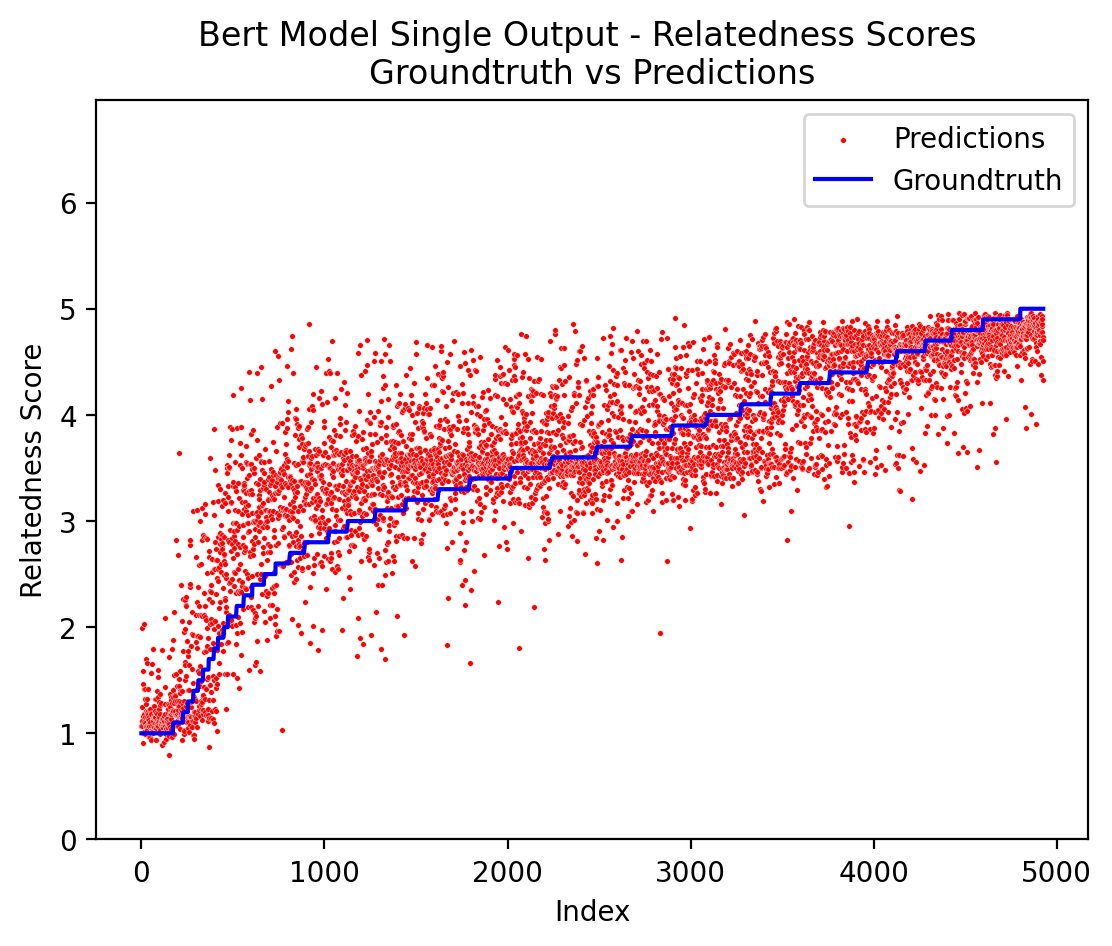

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, ax = plt.subplots(1,1)
fig.dpi = 200
sns.scatterplot(data=sorted_results_test_df, x="index", y="Pred_Rel_Scores", color="red", label="Predictions", s=4)
sns.lineplot(data=sorted_results_test_df, x="index", y="Real_Rel_Scores", color="blue", label="Groundtruth")
ax.set_ylim(0, max(sorted_results_test_df["Pred_Rel_Scores"])+2)
ax.set_xlabel("Index")
ax.set_ylabel("Relatedness Score")
ax.set_title("Bert Model Single Output - Relatedness Scores \nGroundtruth vs Predictions")

In [127]:
label_map = {0: "Neutral", 1: "Entailment", 2: "Contradiction"}
sorted_results_test_df["Real_Entail_Classes_Map"] = sorted_results_test_df["Real_Entail_Classes"].apply(lambda x: label_map[x])
sorted_results_test_df["Pred_Entail_Classes_Map"] = sorted_results_test_df["Pred_Entail_Classes"].apply(lambda x: label_map[x])
sorted_results_test_df

,sentence_pair_id,premise,hypothesis,relatedness_score,entailment_judgment,Real_Rel_Scores,Pred_Rel_Scores,Real_Entail_Classes,Pred_Entail_Classes,index,Real_Entail_Classes_Map,Pred_Entail_Classes_Map
0,9996,A man is in a parking lot and is playing tenni...,The snowboarder is leaping fearlessly over whi...,1.0,0,1.0,1.071684,0,0,0,Neutral,Neutral
1,9995,"The girl, who is little, is combing her hair i...",Two people wearing helmets are driving over th...,1.0,0,1.0,1.114601,0,0,1,Neutral,Neutral
2,9994,A boy is happily playing the piano,A white bird is landing swiftly in the water,1.0,0,1.0,1.115053,0,0,2,Neutral,Neutral
3,1316,A person is performing a card trick,There is no man frying a tortilla,1.0,0,1.0,1.117333,0,0,3,Neutral,Neutral
4,9979,A person is wearing a straw hat and smoking a ...,A dog is near the red ball in the air,1.0,0,1.0,1.251280,0,0,4,Neutral,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...
4922,4775,A boy is playing guitar,A guitar is being played by a boy,5.0,1,5.0,4.901380,1,1,4922,Entailment,Entailment
4923,7128,A brown dog and a black dog are playing in the...,The black dog is playing with the brown dog on...,5.0,1,5.0,4.327777,1,0,4923,Entailment,Neutral
4924,3194,A lady is mixing a meat mixture in a bowl,A lady is mixing a mixture of meat in a bowl,5.0,1,5.0,4.730325,1,1,4924,Entailment,Entailment
4925,7048,A female wearing pink gloves and a brown jacke...,The female wearing pink gloves and a brown jac...,5.0,1,5.0,4.704271,1,1,4925,Entailment,Entailment


In [128]:
from collections import Counter
import pandas as pd
count_labels_real = Counter(sorted_results_test_df["Real_Entail_Classes_Map"])
count_labels_pred = Counter(sorted_results_test_df["Pred_Entail_Classes_Map"])
count_labels_real_df = pd.DataFrame({"Label": count_labels_real.keys(), "Groundtruth": count_labels_real.values()}, columns=["Label", "Groundtruth"])
count_labels_pred_df = pd.DataFrame({"Label": count_labels_pred.keys(), "Predictions": count_labels_pred.values()}, columns=["Label", "Predictions"])
count_labels_df = count_labels_real_df.merge(count_labels_pred_df, on="Label")
# count_labels_df = pd.concat([pd.DataFrame({"Label": count_labels_real.keys(), "Groundtruth": count_labels_real.values()}, columns=["Label", "Groundtruth"]), pd.DataFrame({"Label": count_labels_pred.keys(), "Predictions": count_labels_pred.values()}, columns=["Label", "Predictions"])], axis=1)
count_labels_df

,Label,Groundtruth,Predictions
0,Neutral,2793,3091
1,Entailment,1414,1170
2,Contradiction,720,666


In [129]:
melted_df = count_labels_df.melt(id_vars="Label", var_name="Type", value_name="Count")
melted_df

,Label,Type,Count
0,Neutral,Groundtruth,2793
1,Entailment,Groundtruth,1414
2,Contradiction,Groundtruth,720
3,Neutral,Predictions,3091
4,Entailment,Predictions,1170
5,Contradiction,Predictions,666


Text(0.5, 1.0, 'Bert Model Single Output - Entailment Judgement \nGroundtruth vs Predictions')

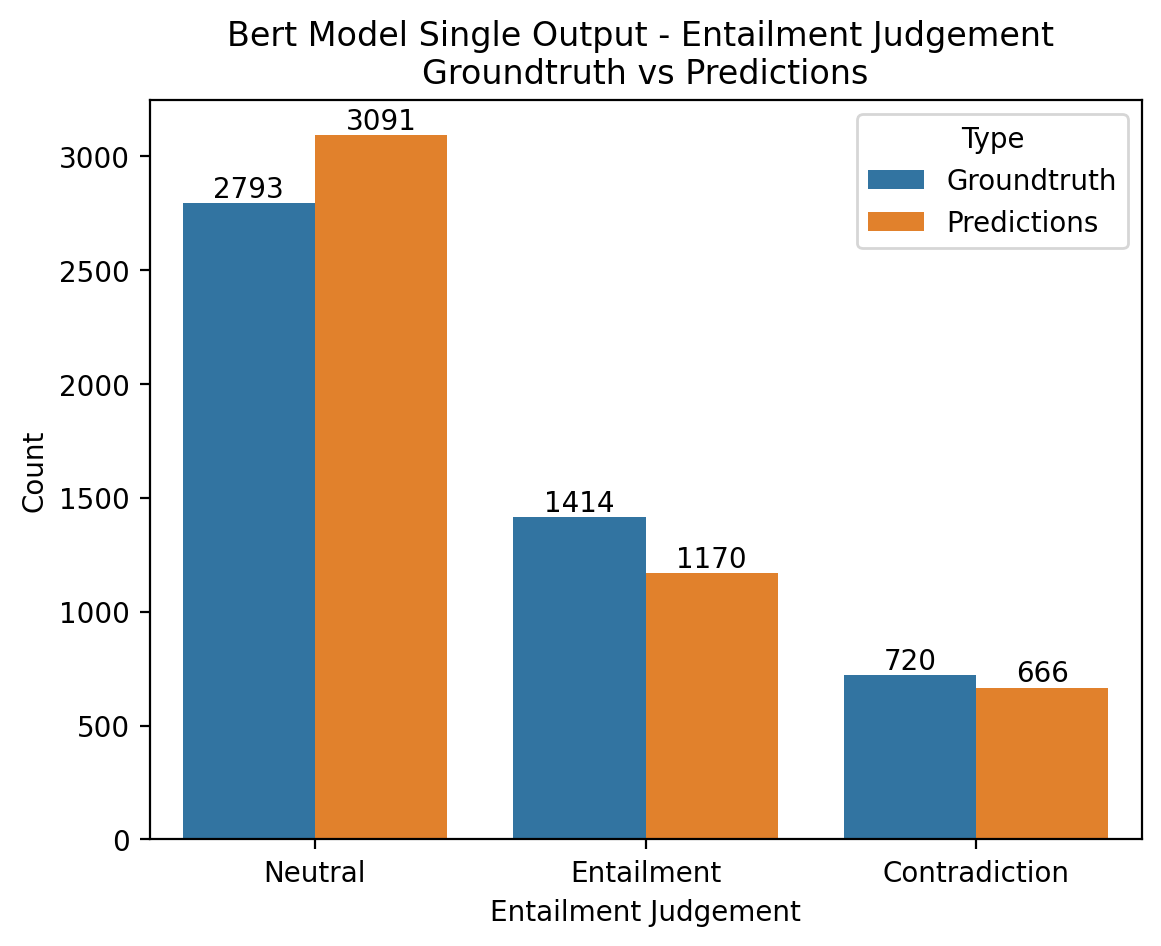

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, ax = plt.subplots(1,1)
fig.dpi = 200
sns.barplot(data=melted_df, x = "Label", y="Count", hue="Type")
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
# for index, row in melted_df.iterrows():
#     ax.text(index, row['Count'], round(row['Count'], 2),
#             color='black', ha='center', va='bottom')
ax.set_xlabel("Entailment Judgement")
ax.set_ylabel("Count")
ax.set_title("Bert Model Single Output - Entailment Judgement \nGroundtruth vs Predictions")

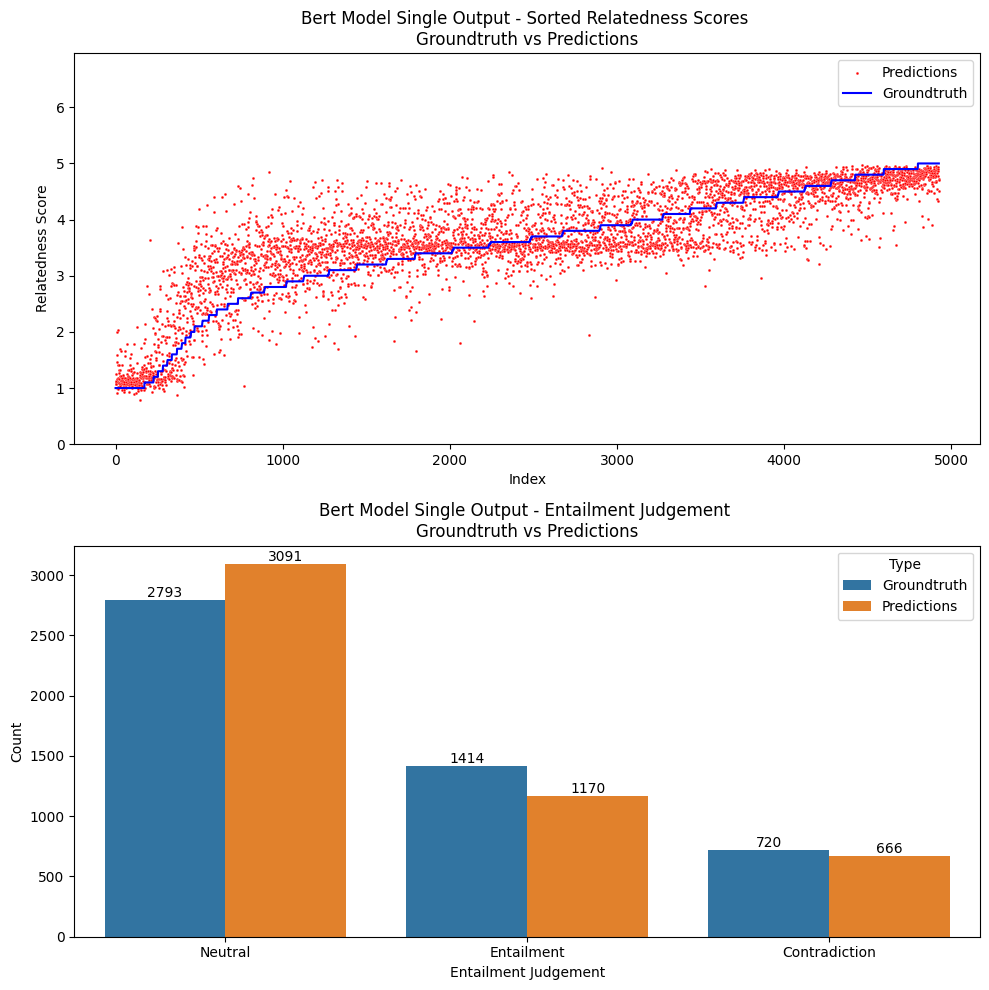

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


fig, ax = plt.subplots(2,1, figsize=(10, 10))
fig.dpi = 100

sns.scatterplot(data=sorted_results_test_df, x="index", y="Pred_Rel_Scores", color="red", label="Predictions", s=4, ax=ax[0])
sns.lineplot(data=sorted_results_test_df, x="index", y="Real_Rel_Scores", color="blue", label="Groundtruth", ax=ax[0])
ax[0].set_ylim(0, max(sorted_results_test_df["Pred_Rel_Scores"])+2)
ax[0].set_xlabel("Index")
ax[0].set_ylabel("Relatedness Score")
ax[0].set_title("Bert Model Single Output - Sorted Relatedness Scores \nGroundtruth vs Predictions")

sns.barplot(data=melted_df, x = "Label", y="Count", hue="Type", ax=ax[1])
ax[1].bar_label(ax[1].containers[0])
ax[1].bar_label(ax[1].containers[1])
ax[1].set_xlabel("Entailment Judgement")
ax[1].set_ylabel("Count")
ax[1].set_title("Bert Model Single Output - Entailment Judgement \nGroundtruth vs Predictions")
plt.tight_layout()

In [132]:
sorted_results_test_df.describe()

,sentence_pair_id,relatedness_score,entailment_judgment,Real_Rel_Scores,Pred_Rel_Scores,Real_Entail_Classes,Pred_Entail_Classes,index
count,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000
mean,5001.250457,3.530021,0.579257,3.530021,3.655472,0.579257,0.507814,2463.000000
std,2915.057191,1.008868,0.732185,1.008868,0.935858,0.732185,0.721382,1422.446718
min,6.000000,1.000000,0.000000,1.000000,0.794050,0.000000,0.000000,0.000000
25%,2457.000000,3.000000,0.000000,3.000000,3.329438,0.000000,0.000000,1231.500000
50%,5038.000000,3.600000,0.000000,3.600000,3.667443,0.000000,0.000000,2463.000000
75%,7523.500000,4.300000,1.000000,4.300000,4.421250,1.000000,1.000000,3694.500000
max,9996.000000,5.000000,2.000000,5.000000,4.964393,2.000000,2.000000,4926.000000


In [133]:
sorted_results_test_df

,sentence_pair_id,premise,hypothesis,relatedness_score,entailment_judgment,Real_Rel_Scores,Pred_Rel_Scores,Real_Entail_Classes,Pred_Entail_Classes,index,Real_Entail_Classes_Map,Pred_Entail_Classes_Map
0,9996,A man is in a parking lot and is playing tenni...,The snowboarder is leaping fearlessly over whi...,1.0,0,1.0,1.071684,0,0,0,Neutral,Neutral
1,9995,"The girl, who is little, is combing her hair i...",Two people wearing helmets are driving over th...,1.0,0,1.0,1.114601,0,0,1,Neutral,Neutral
2,9994,A boy is happily playing the piano,A white bird is landing swiftly in the water,1.0,0,1.0,1.115053,0,0,2,Neutral,Neutral
3,1316,A person is performing a card trick,There is no man frying a tortilla,1.0,0,1.0,1.117333,0,0,3,Neutral,Neutral
4,9979,A person is wearing a straw hat and smoking a ...,A dog is near the red ball in the air,1.0,0,1.0,1.251280,0,0,4,Neutral,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...
4922,4775,A boy is playing guitar,A guitar is being played by a boy,5.0,1,5.0,4.901380,1,1,4922,Entailment,Entailment
4923,7128,A brown dog and a black dog are playing in the...,The black dog is playing with the brown dog on...,5.0,1,5.0,4.327777,1,0,4923,Entailment,Neutral
4924,3194,A lady is mixing a meat mixture in a bowl,A lady is mixing a mixture of meat in a bowl,5.0,1,5.0,4.730325,1,1,4924,Entailment,Entailment
4925,7048,A female wearing pink gloves and a brown jacke...,The female wearing pink gloves and a brown jac...,5.0,1,5.0,4.704271,1,1,4925,Entailment,Entailment


In [134]:
sorted_results_test_df["Rel_Score_Diff"] = sorted_results_test_df.apply(lambda row: abs(row.Real_Rel_Scores-row.Pred_Rel_Scores), axis=1)
sorted_results_test_df

,sentence_pair_id,premise,hypothesis,relatedness_score,entailment_judgment,Real_Rel_Scores,Pred_Rel_Scores,Real_Entail_Classes,Pred_Entail_Classes,index,Real_Entail_Classes_Map,Pred_Entail_Classes_Map,Rel_Score_Diff
0,9996,A man is in a parking lot and is playing tenni...,The snowboarder is leaping fearlessly over whi...,1.0,0,1.0,1.071684,0,0,0,Neutral,Neutral,0.071684
1,9995,"The girl, who is little, is combing her hair i...",Two people wearing helmets are driving over th...,1.0,0,1.0,1.114601,0,0,1,Neutral,Neutral,0.114601
2,9994,A boy is happily playing the piano,A white bird is landing swiftly in the water,1.0,0,1.0,1.115053,0,0,2,Neutral,Neutral,0.115053
3,1316,A person is performing a card trick,There is no man frying a tortilla,1.0,0,1.0,1.117333,0,0,3,Neutral,Neutral,0.117333
4,9979,A person is wearing a straw hat and smoking a ...,A dog is near the red ball in the air,1.0,0,1.0,1.251280,0,0,4,Neutral,Neutral,0.251280
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4922,4775,A boy is playing guitar,A guitar is being played by a boy,5.0,1,5.0,4.901380,1,1,4922,Entailment,Entailment,0.098620
4923,7128,A brown dog and a black dog are playing in the...,The black dog is playing with the brown dog on...,5.0,1,5.0,4.327777,1,0,4923,Entailment,Neutral,0.672223
4924,3194,A lady is mixing a meat mixture in a bowl,A lady is mixing a mixture of meat in a bowl,5.0,1,5.0,4.730325,1,1,4924,Entailment,Entailment,0.269675
4925,7048,A female wearing pink gloves and a brown jacke...,The female wearing pink gloves and a brown jac...,5.0,1,5.0,4.704271,1,1,4925,Entailment,Entailment,0.295729


In [135]:
sorted_rel_score_diff_df = sorted_results_test_df.sort_values(by="Rel_Score_Diff", ignore_index=True)
sorted_rel_score_diff_df

,sentence_pair_id,premise,hypothesis,relatedness_score,entailment_judgment,Real_Rel_Scores,Pred_Rel_Scores,Real_Entail_Classes,Pred_Entail_Classes,index,Real_Entail_Classes_Map,Pred_Entail_Classes_Map,Rel_Score_Diff
0,9812,A small man is sitting in a military accessori...,The person is slicing onions,1.00,0,1.00,1.000034,0,0,51,Neutral,Neutral,0.000034
1,2901,A tree is being cut by a man with an axe,A man is cutting a tree with an axe,4.90,1,4.90,4.899889,1,1,4764,Entailment,Entailment,0.000111
2,7170,A dog is standing with its two front paws on a...,The black dog is not climbing on a rock,3.00,0,3.00,3.000217,0,0,1264,Neutral,Neutral,0.000217
3,8788,A young girl is jumping rope on a sidewalk nea...,A girl is jumping rope on a sidewalk near a pa...,4.70,1,4.70,4.699698,1,1,4360,Entailment,Entailment,0.000301
4,4270,A person is quickly cutting mushrooms with a k...,A man is rapidly chopping some mushrooms with ...,4.70,1,4.70,4.700366,1,1,4352,Entailment,Entailment,0.000366
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4922,1546,A cat is playing a keyboard,A man is playing two keyboards,2.10,0,2.10,4.191929,0,0,500,Neutral,Neutral,2.091929
4923,3612,A bicycle is being ridden by a man,A monkey is riding a bike,2.50,0,2.50,4.603065,0,0,732,Neutral,Neutral,2.103065
4924,1542,A cat is playing a keyboard,A musician is playing two keyboards,2.30,0,2.30,4.406981,0,0,586,Neutral,Neutral,2.106981
4925,1911,The windows are being cleaned by a man,The man has a window of time to clean himself,1.75,0,1.75,3.862485,0,0,396,Neutral,Neutral,2.112485


In [139]:
sorted_rel_score_diff_df[-5:]

,sentence_pair_id,premise,hypothesis,relatedness_score,entailment_judgment,Real_Rel_Scores,Pred_Rel_Scores,Real_Entail_Classes,Pred_Entail_Classes,index,Real_Entail_Classes_Map,Pred_Entail_Classes_Map,Rel_Score_Diff
4922,1546,A cat is playing a keyboard,A man is playing two keyboards,2.10,0,2.10,4.191929,0,0,500,Neutral,Neutral,2.091929
4923,3612,A bicycle is being ridden by a man,A monkey is riding a bike,2.50,0,2.50,4.603065,0,0,732,Neutral,Neutral,2.103065
4924,1542,A cat is playing a keyboard,A musician is playing two keyboards,2.30,0,2.30,4.406981,0,0,586,Neutral,Neutral,2.106981
4925,1911,The windows are being cleaned by a man,The man has a window of time to clean himself,1.75,0,1.75,3.862485,0,0,396,Neutral,Neutral,2.112485
4926,5224,A cat is looking at a store counter,A dog is looking around,1.10,0,1.10,3.643344,0,0,206,Neutral,Neutral,2.543344
